<a href="https://colab.research.google.com/github/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/blob/main/Implementa%C3%A7%C3%A3o_e_An%C3%A1lise_do_Algoritmo_de_K_means_com_o_Dataset_Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Activity Labels:
   id            activity
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING

Features:
   id            feature
0   1  tBodyAcc-mean()-X
1   2  tBodyAcc-mean()-Y
2   3  tBodyAcc-mean()-Z
3   4   tBodyAcc-std()-X
4   5   tBodyAcc-std()-Y

Dimensões de X_train: (7352, 561)
Dimensões de X_test: (2947, 561)
Dimensões de y_train: (7352,)
Dimensões de y_test: (2947,)

Resultados das Execuções do K-means:
Execução 1: Inércia = 207069.80, Silhouette Score = 0.70
Execução 2: Inércia = 207069.80, Silhouette Score = 0.70
Execução 3: Inércia = 207069.80, Silhouette Score = 0.70
Execução 4: Inércia = 207069.80, Silhouette Score = 0.70
Execução 5: Inércia = 207069.80, Silhouette Score = 0.70
Execução 6: Inércia = 207069.80, Silhouette Score = 0.70
Execução 7: Inércia = 207069.80, Silhouette Score = 0.70
Execução 8: Inércia = 207069.80, Silhouette Score = 0.70
Execução 9: Inércia = 207069.80, Silhouette S

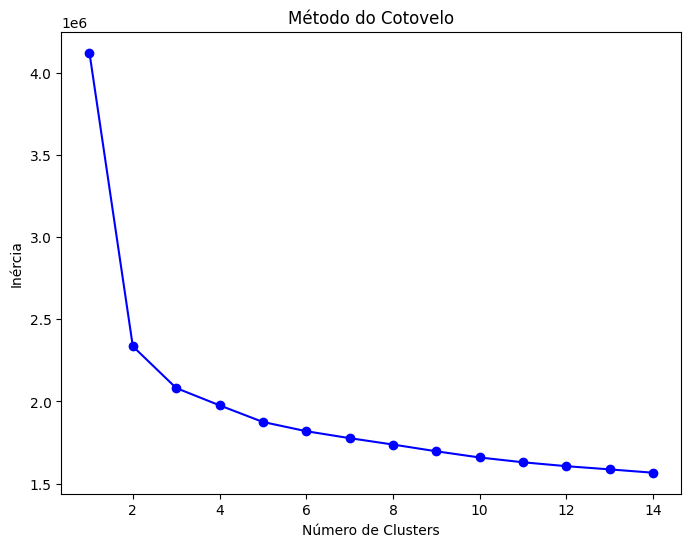

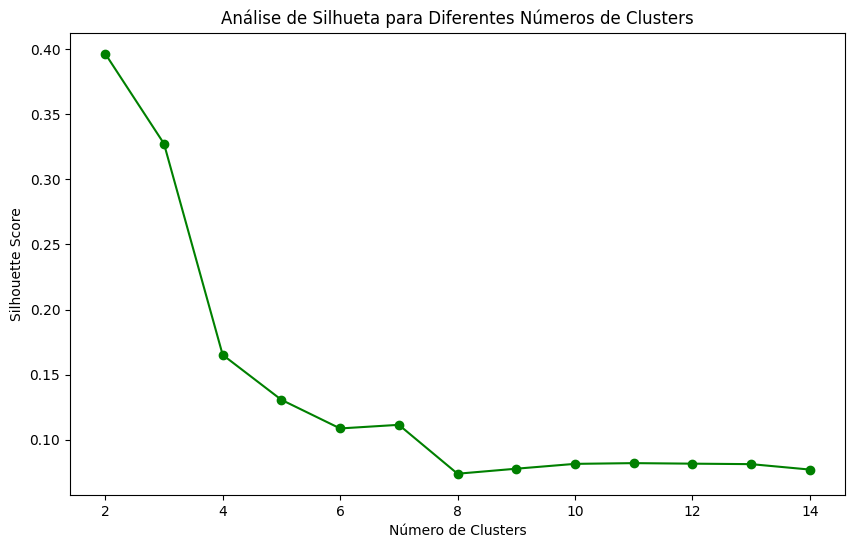

O número ótimo de clusters com base na análise de silhueta é 2

Inércia (Treino Final): 207069.80464675982
Silhouette Score (Treino Final): 0.7029330769783646
Silhouette Score (Teste): 0.7003429209798128

Distribuição das atividades nos clusters (Teste):
y_test   1.0  2.0  3.0  4.0  5.0  6.0
Cluster                              
0          0    0    0  490  532  536
1        496  471  420    1    0    1


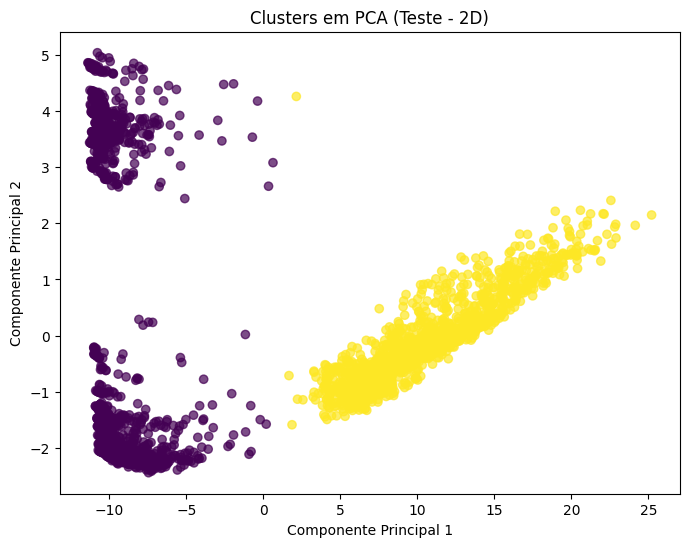

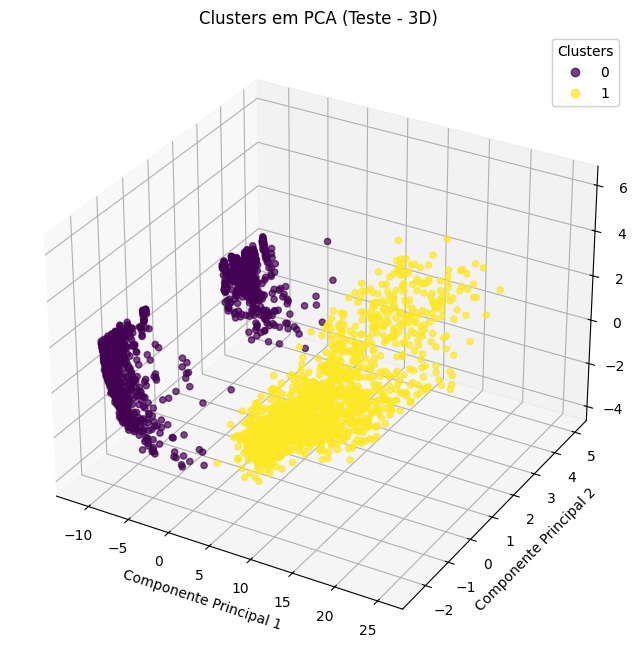

In [10]:
# Importação das bibliotecas necessárias
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # Para visualização 3D
from sklearn.feature_selection import f_classif
from sklearn.manifold import TSNE

# Função para carregar arquivos raw do GitHub
def load_github_file(url, is_text=False):
    response = requests.get(url)
    if response.status_code == 200:
        if is_text:
            return pd.read_csv(io.StringIO(response.text), header=None, sep=' ')  # Usando pandas para ler o arquivo de texto
        else:
            return np.loadtxt(io.StringIO(response.text))
    else:
        raise Exception(f"Erro ao carregar o arquivo: {url}")

# URLs dos arquivos raw no GitHub
url_X_train = "https://raw.githubusercontent.com/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/refs/heads/master/train/X_train.txt"
url_y_train = "https://raw.githubusercontent.com/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/refs/heads/master/train/y_train.txt"
url_X_test = "https://raw.githubusercontent.com/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/refs/heads/master/test/X_test.txt"
url_y_test = "https://raw.githubusercontent.com/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/refs/heads/master/test/y_test.txt"
url_activity_labels = "https://raw.githubusercontent.com/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/refs/heads/master/activity_labels.txt"
url_features = "https://raw.githubusercontent.com/VeectorVt/Implementacao_e_Analise_do_Algoritmo_de_K-means_com_o_Dataset_Human_Activity_Recognition/refs/heads/master/features.txt"

# Carregar os dados de treino e teste
X_train = load_github_file(url_X_train)  # Características de treino
y_train = load_github_file(url_y_train)  # Rótulos de treino
X_test = load_github_file(url_X_test)    # Características de teste
y_test = load_github_file(url_y_test)    # Rótulos de teste

# Carregar os arquivos de mapeamento
activity_labels = load_github_file(url_activity_labels, is_text=True)
activity_labels.columns = ['id', 'activity']  # Nomear as colunas

features = load_github_file(url_features, is_text=True)
features.columns = ['id', 'feature']  # Nomear as colunas

# Verificar os dados carregados
print("Activity Labels:")
print(activity_labels.head())

print("\nFeatures:")
print(features.head())

print("\nDimensões de X_train:", X_train.shape)
print("Dimensões de X_test:", X_test.shape)
print("Dimensões de y_train:", y_train.shape)
print("Dimensões de y_test:", y_test.shape)

# **1. Normalização dos Dados**
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizar os dados de treino
X_test_scaled = scaler.transform(X_test)        # Aplicar a mesma transformação no teste

# **2. Seleção de Características usando ANOVA**
f_scores, _ = f_classif(X_train_scaled, y_train)
threshold = np.percentile(f_scores, 75)  # Seleciona características no top 25%
selected_features = f_scores > threshold
X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

# **3. Execuções Múltiplas do K-means para Verificação de Estabilidade**
n_runs = 10  # Número de execuções para verificar a estabilidade
inertia_values = []
silhouette_values = []

for i in range(n_runs):
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=i)
    kmeans.fit(X_train_selected)
    inertia_values.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_train_selected, kmeans.labels_)
    silhouette_values.append(silhouette_avg)

# Mostrar os resultados das múltiplas execuções
print("\nResultados das Execuções do K-means:")
for i in range(n_runs):
    print(f"Execução {i + 1}: Inércia = {inertia_values[i]:.2f}, Silhouette Score = {silhouette_values[i]:.2f}")

# **4. Avaliação da Estabilidade**
print("\nMédia e Desvio Padrão das Métricas:")
print(f"Inércia média: {np.mean(inertia_values):.2f}, Desvio padrão: {np.std(inertia_values):.2f}")
print(f"Silhouette Score médio: {np.mean(silhouette_values):.2f}, Desvio padrão: {np.std(silhouette_values):.2f}")

# **5. Método do Cotovelo para Encontrar o Número Ideal de Clusters**
range_clusters = range(1, 15)  # Testar de 1 a 14 clusters
inertia_values = []

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    inertia_values.append(kmeans.inertia_)

# Visualizar o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range_clusters, inertia_values, marker='o', color='blue')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

# **6. Análise de Silhueta para Escolher o Número de Clusters**
range_clusters = range(2, 15)  # Testar de 2 a 14 clusters
silhouette_scores = []

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    silhouette_avg = silhouette_score(X_train_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Visualizar o gráfico de Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, marker='o', color='green')
plt.title('Análise de Silhueta para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Escolher o número de clusters com base na análise de silhueta
optimal_k = range_clusters[np.argmax(silhouette_scores)]
print(f'O número ótimo de clusters com base na análise de silhueta é {optimal_k}')

# **7. Treinamento do K-means Final com Melhor Configuração**
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans_final.fit(X_train_selected)

# Obter rótulos dos clusters e centroides
train_labels = kmeans_final.labels_
test_labels = kmeans_final.predict(X_test_selected)  # Prever clusters para o conjunto de teste
centroids = kmeans_final.cluster_centers_

# **8. Métricas de Avaliação no Conjunto de Treino**
inertia_final = kmeans_final.inertia_
silhouette_avg_final = silhouette_score(X_train_selected, kmeans_final.labels_)
print(f"\nInércia (Treino Final): {inertia_final}")
print(f"Silhouette Score (Treino Final): {silhouette_avg_final}")

# **9. Métricas de Avaliação no Conjunto de Teste**
silhouette_test = silhouette_score(X_test_selected, test_labels)
print(f"Silhouette Score (Teste): {silhouette_test}")

# **10. Comparação dos Clusters com y_test**
test_comparison = pd.DataFrame({'y_test': y_test, 'Cluster': test_labels})
cluster_activity_dist_test = test_comparison.groupby(['Cluster', 'y_test']).size().unstack(fill_value=0)
print("\nDistribuição das atividades nos clusters (Teste):")
print(cluster_activity_dist_test)

# **11. Visualização em PCA (Conjunto de Teste - 2D)**
pca_2d_test = PCA(n_components=2)
X_test_pca_2d = pca_2d_test.fit_transform(X_test_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca_2d[:, 0], X_test_pca_2d[:, 1], c=test_labels, cmap='viridis', alpha=0.7)
plt.title('Clusters em PCA (Teste - 2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# **12. Visualização em PCA (Conjunto de Teste - 3D)**
pca_3d_test = PCA(n_components=3)
X_test_pca_3d = pca_3d_test.fit_transform(X_test_selected)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca_3d[:, 0], X_test_pca_3d[:, 1], X_test_pca_3d[:, 2], c=test_labels, cmap='viridis', alpha=0.7)
ax.set_title('Clusters em PCA (Teste - 3D)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

# Adicionar a legenda
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()
